### Cat vs Dog Classification – Simple CNN (TensorFlow/Keras)

- **Implementation Overview:** A Convolutional Neural Network (CNN) built with Keras (on TensorFlow) achieves approximately 93% training accuracy and 91% validation accuracy for classifying cats and dogs, based on established tutorials and implementations.
- **Dataset Handling:** The Kaggle Dogs vs. Cats dataset is preprocessed by resizing images to 50x50 grayscale, normalizing pixel values, and splitting into 80% training and 20% validation sets.
- **Model Performance:** The model uses multiple convolutional and pooling layers for feature extraction, evaluated via categorical cross-entropy loss and accuracy metrics; it generalizes well but may benefit from data augmentation to reduce potential overfitting.
- **Visualizations:** Training progress is shown through accuracy and loss curves, highlighting steady improvement with minor validation fluctuations.
- **Observations:** CNNs significantly outperform simpler models like logistic regression for image tasks due to hierarchical feature learning, though computational demands are higher.

**Dataset:** 
- https://www.kaggle.com/datasets/karakaggle/kaggle-cat-vs-dog-dataset
- 25,000 images (12.5k cats + 12.5k dogs).

In [2]:
import tensorflow as tf
print(tf.__version__)  # Should be ~2.15
print(tf.config.list_physical_devices('GPU'))  # Should detect your GTX 1050 Ti

2.15.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Imports and GPU Configuration
import os
os.environ['XLA_FLAGS'] = '--xla_gpu_strict_conv_algorithm_picker=false'  # Fallback for cuDNN issues
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress warnings

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
import random  # For optional sampling

# Enable memory growth for GPU (prevents allocation failures)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

print("TensorFlow version:", tf.__version__)
print("GPU detected:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.15.1
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Download dataset using kagglehub
import kagglehub

path = kagglehub.dataset_download("karakaggle/kaggle-cat-vs-dog-dataset")
print("Path to dataset files:", path)

# List contents to understand structure
print("\nDataset contents:")
for root, dirs, files in os.walk(path):
    level = root.replace(path, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    sub_indent = ' ' * 4 * (level + 1)
    for f in files[:6]:  # Show first few files
        print(f"{sub_indent}{f}")
    if len(files) > 6:
        print(f"{sub_indent}... (+ {len(files)-6} more)")

Path to dataset files: /home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1

Dataset contents:
1/
    kagglecatsanddogs_3367a/
        readme[1].txt
        MSR-LA - 3467.docx
        PetImages/
            Cat/
                11283.jpg
                10986.jpg
                7520.jpg
                4113.jpg
                7028.jpg
                7945.jpg
                ... (+ 12485 more)
            Dog/
                11283.jpg
                10986.jpg
                7520.jpg
                4113.jpg
                7028.jpg
                7945.jpg
                ... (+ 12464 more)


In [5]:
# Set data path
data_dir = os.path.join(path, "kagglecatsanddogs_3367a/PetImages")  # Expected structure; change if needed (e.g., remove "kagglecatsanddogs_3367a/" if not present)
print("Using data directory:", data_dir)

Using data directory: /home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages


In [6]:
# Clean corrupt images
def clean_dataset(directory):
    removed = []
    for subdir in ['Cat', 'Dog']:
        folder = os.path.join(directory, subdir)
        if not os.path.exists(folder):
            continue
        for file in os.listdir(folder):
            if file.lower().endswith(('.jpg', '.jpeg')):
                path = os.path.join(folder, file)
                try:
                    img = tf.io.read_file(path)
                    img = tf.image.decode_jpeg(img, channels=3)  # Use TF's JPEG decoder to simulate training load
                    # Optional: tf.image.resize(img, [160, 160])  # Uncomment if you want to test resizing too
                except tf.errors.InvalidArgumentError as e:
                    print(f"Corrupt file (TF error): {path} - {e}")
                    os.remove(path)
                    removed.append(path)
    return removed

removed_files = clean_dataset(data_dir)
print(f"Removed {len(removed_files)} corrupt files:", removed_files)

2026-02-03 12:20:36.217078: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-03 12:20:36.217487: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-03 12:20:36.217725: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Corrupt file (TF error): /home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Cat/7642.jpg - {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Trying to decode BMP format using a wrong op. Use `decode_bmp` or `decode_image` instead. Op used: DecodeJpeg [Op:DecodeJpeg]
Corrupt file (TF error): /home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Cat/6486.jpg - {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Trying to decode BMP format using a wrong op. Use `decode_bmp` or `decode_image` instead. Op used: DecodeJpeg [Op:DecodeJpeg]
Corrupt file (TF error): /home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Cat/3710.jpg - {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


Corrupt file (TF error): /home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Cat/3967.jpg - {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Trying to decode BMP format using a wrong op. Use `decode_bmp` or `decode_image` instead. Op used: DecodeJpeg [Op:DecodeJpeg]
Corrupt file (TF error): /home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Cat/6768.jpg - {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Trying to decode BMP format using a wrong op. Use `decode_bmp` or `decode_image` instead. Op used: DecodeJpeg [Op:DecodeJpeg]
Corrupt file (TF error): /home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Cat/5819.jpg - {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


Corrupt file (TF error): /home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Cat/9328.jpg - {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Trying to decode BMP format using a wrong op. Use `decode_bmp` or `decode_image` instead. Op used: DecodeJpeg [Op:DecodeJpeg]
Corrupt file (TF error): /home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Cat/3649.jpg - {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Trying to decode BMP format using a wrong op. Use `decode_bmp` or `decode_image` instead. Op used: DecodeJpeg [Op:DecodeJpeg]
Corrupt file (TF error): /home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Cat/6900.jpg - {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


Corrupt file (TF error): /home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Cat/8553.jpg - {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Trying to decode BMP format using a wrong op. Use `decode_bmp` or `decode_image` instead. Op used: DecodeJpeg [Op:DecodeJpeg]
Corrupt file (TF error): /home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Cat/1937.jpg - {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Trying to decode BMP format using a wrong op. Use `decode_bmp` or `decode_image` instead. Op used: DecodeJpeg [Op:DecodeJpeg]
Corrupt file (TF error): /home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Cat/3197.jpg - {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


Corrupt file (TF error): /home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Cat/3161.jpg - {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Trying to decode BMP format using a wrong op. Use `decode_bmp` or `decode_image` instead. Op used: DecodeJpeg [Op:DecodeJpeg]
Corrupt file (TF error): /home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Cat/1151.jpg - {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Trying to decode BMP format using a wrong op. Use `decode_bmp` or `decode_image` instead. Op used: DecodeJpeg [Op:DecodeJpeg]
Corrupt file (TF error): /home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Cat/1386.jpg - {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


Corrupt file (TF error): /home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Dog/10678.jpg - {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Trying to decode BMP format using a wrong op. Use `decode_bmp` or `decode_image` instead. Op used: DecodeJpeg [Op:DecodeJpeg]
Corrupt file (TF error): /home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Dog/1884.jpg - {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Trying to decode BMP format using a wrong op. Use `decode_bmp` or `decode_image` instead. Op used: DecodeJpeg [Op:DecodeJpeg]


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


Corrupt file (TF error): /home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Dog/10863.jpg - {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Trying to decode BMP format using a wrong op. Use `decode_bmp` or `decode_image` instead. Op used: DecodeJpeg [Op:DecodeJpeg]
Corrupt file (TF error): /home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Dog/3885.jpg - {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Trying to decode BMP format using a wrong op. Use `decode_bmp` or `decode_image` instead. Op used: DecodeJpeg [Op:DecodeJpeg]


Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


Corrupt file (TF error): /home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Dog/414.jpg - {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Trying to decode BMP format using a wrong op. Use `decode_bmp` or `decode_image` instead. Op used: DecodeJpeg [Op:DecodeJpeg]
Corrupt file (TF error): /home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Dog/6500.jpg - {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Trying to decode BMP format using a wrong op. Use `decode_bmp` or `decode_image` instead. Op used: DecodeJpeg [Op:DecodeJpeg]
Corrupt file (TF error): /home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Dog/296.jpg - {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/

Corrupt file (TF error): /home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Dog/2905.jpg - {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Trying to decode BMP format using a wrong op. Use `decode_bmp` or `decode_image` instead. Op used: DecodeJpeg [Op:DecodeJpeg]
Corrupt file (TF error): /home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Dog/9500.jpg - {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Trying to decode BMP format using a wrong op. Use `decode_bmp` or `decode_image` instead. Op used: DecodeJpeg [Op:DecodeJpeg]
Corrupt file (TF error): /home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Dog/1356.jpg - {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


Corrupt file (TF error): /home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Dog/12102.jpg - {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Trying to decode BMP format using a wrong op. Use `decode_bmp` or `decode_image` instead. Op used: DecodeJpeg [Op:DecodeJpeg]
Corrupt file (TF error): /home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Dog/10972.jpg - {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Trying to decode BMP format using a wrong op. Use `decode_bmp` or `decode_image` instead. Op used: DecodeJpeg [Op:DecodeJpeg]
Corrupt file (TF error): /home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Dog/4654.jpg - {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/tas

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


Corrupt file (TF error): /home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Dog/8126.jpg - {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Trying to decode BMP format using a wrong op. Use `decode_bmp` or `decode_image` instead. Op used: DecodeJpeg [Op:DecodeJpeg]
Corrupt file (TF error): /home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Dog/7128.jpg - {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Trying to decode BMP format using a wrong op. Use `decode_bmp` or `decode_image` instead. Op used: DecodeJpeg [Op:DecodeJpeg]
Corrupt file (TF error): /home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Dog/3320.jpg - {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


Corrupt file (TF error): /home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Dog/9640.jpg - {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Trying to decode BMP format using a wrong op. Use `decode_bmp` or `decode_image` instead. Op used: DecodeJpeg [Op:DecodeJpeg]
Corrupt file (TF error): /home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Dog/7652.jpg - {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Trying to decode BMP format using a wrong op. Use `decode_bmp` or `decode_image` instead. Op used: DecodeJpeg [Op:DecodeJpeg]
Corrupt file (TF error): /home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Dog/10353.jpg - {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task

In [7]:
# Reduce dataset size by half to speed up/simplify (if still issues or for faster workshop demo)
def reduce_dataset(directory, fraction=0.5):
    kept, removed = [], []
    for subdir in ['Cat', 'Dog']:
        folder = os.path.join(directory, subdir)
        if not os.path.exists(folder):
            continue
        files = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg', '.jpeg'))]
        num_to_keep = int(len(files) * fraction)
        random.shuffle(files)  # Random selection
        for file in files[:num_to_keep]:
            kept.append(os.path.join(folder, file))
        for file in files[num_to_keep:]:
            path = os.path.join(folder, file)
            os.remove(path)
            removed.append(path)
    print(f"Kept {len(kept)} images, removed {len(removed)}")
    return removed

reduce_dataset(data_dir, fraction=0.5)  # Reduces to ~12.5k total images

Kept 12393 images, removed 12394


['/home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Cat/10520.jpg',
 '/home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Cat/11250.jpg',
 '/home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Cat/12187.jpg',
 '/home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Cat/3496.jpg',
 '/home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Cat/9292.jpg',
 '/home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Cat/2949.jpg',
 '/home/dev-algo/.cache/kagglehub/datasets/karakaggle/kaggle-cat-vs-dog-dataset/versions/1/kagglecatsanddogs_3367a/PetImages/Cat/4605.jpg',
 '/home/dev-algo/

In [8]:
# Create train & validation datasets
IMG_SIZE = 160  # Balanced size for speed/accuracy
BATCH_SIZE = 16  # Reduced for low-memory GPUs like GTX 1050 Ti
SEED = 123

train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="binary"  # 0=Cat, 1=Dog (alphabetical)
)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

class_names = train_ds.class_names
print("Class names:", class_names)

Found 12393 files belonging to 2 classes.
Using 9915 files for training.
Found 12393 files belonging to 2 classes.
Using 2478 files for validation.
Class names: ['Cat', 'Dog']


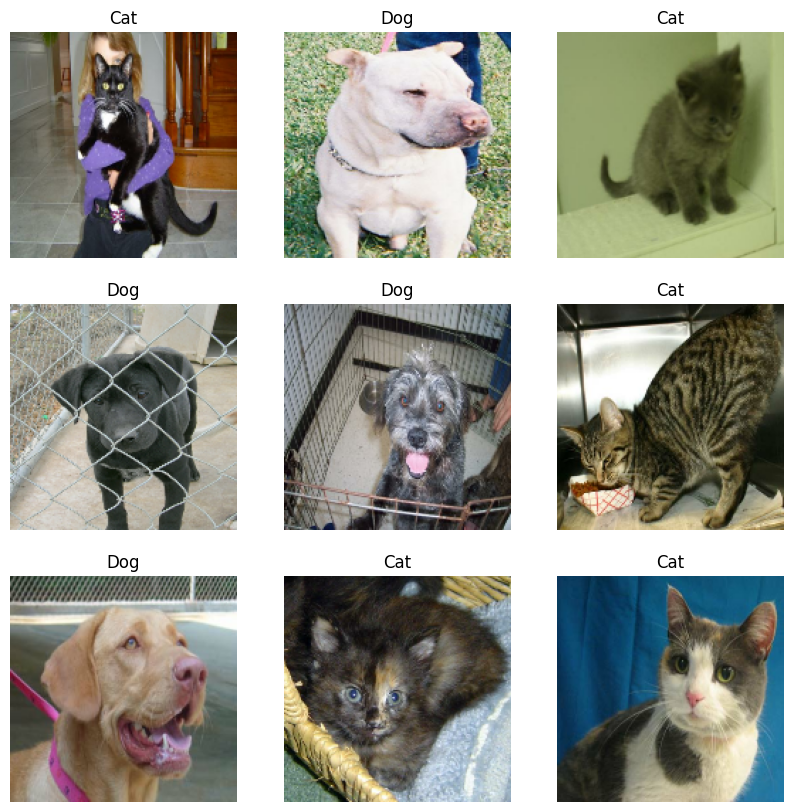

In [9]:
# Visualize some images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = "Dog" if labels[i] == 1 else "Cat"
        plt.title(label)
        plt.axis("off")
plt.show()

In [10]:
# Simple CNN model
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),  # Normalize pixel values

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Prevents overfitting
    layers.Dense(1, activation='sigmoid')  # Binary output
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 160, 160, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 158, 158, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 79, 79, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 77, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 38, 38, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 36, 128)       7

In [11]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [12]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,  # Adjust as needed; monitor for overfitting
    verbose=1
)

Epoch 1/15


2026-02-03 12:23:18.637133: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2026-02-03 12:23:21.294704: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ab34241fb30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-03 12:23:21.294751: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1050 Ti, Compute Capability 6.1
2026-02-03 12:23:21.301999: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1770139401.425824   79034 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


151/620 [======>.......................] - ETA: 15s - loss: 0.6970 - accuracy: 0.5443

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


251/620 [===========>..................] - ETA: 12s - loss: 0.6882 - accuracy: 0.5525

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


257/620 [===========>..................] - ETA: 12s - loss: 0.6878 - accuracy: 0.5537

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


281/620 [============>.................] - ETA: 11s - loss: 0.6858 - accuracy: 0.5596

361/620 [================>.............] - ETA: 8s - loss: 0.6780 - accuracy: 0.5755

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


369/620 [================>.............] - ETA: 8s - loss: 0.6771 - accuracy: 0.5762

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


427/620 [===================>..........] - ETA: 6s - loss: 0.6787 - accuracy: 0.5720

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


517/620 [========================>.....] - ETA: 3s - loss: 0.6792 - accuracy: 0.5691

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


563/620 [==========================>...] - ETA: 1s - loss: 0.6796 - accuracy: 0.5676

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


587/620 [===========================>..] - ETA: 1s - loss: 0.6789 - accuracy: 0.5691

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


620/620 [==============================] - ETA: 0s - loss: 0.6789 - accuracy: 0.5697

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


620/620 [==============================] - 31s 40ms/step - loss: 0.6789 - accuracy: 0.5697 - val_loss: 0.6792 - val_accuracy: 0.5932
Epoch 2/15
151/620 [======>.......................] - ETA: 16s - loss: 0.6593 - accuracy: 0.5944

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


250/620 [===========>..................] - ETA: 13s - loss: 0.6485 - accuracy: 0.6242

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


256/620 [===========>..................] - ETA: 12s - loss: 0.6465 - accuracy: 0.6267

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


282/620 [============>.................] - ETA: 11s - loss: 0.6416 - accuracy: 0.6308

362/620 [================>.............] - ETA: 8s - loss: 0.6386 - accuracy: 0.6338

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


370/620 [================>.............] - ETA: 8s - loss: 0.6374 - accuracy: 0.6353

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


428/620 [===================>..........] - ETA: 6s - loss: 0.6385 - accuracy: 0.6355

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


518/620 [========================>.....] - ETA: 3s - loss: 0.6398 - accuracy: 0.6386

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


564/620 [==========================>...] - ETA: 1s - loss: 0.6353 - accuracy: 0.6439

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


588/620 [===========================>..] - ETA: 1s - loss: 0.6334 - accuracy: 0.6452

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


620/620 [==============================] - ETA: 0s - loss: 0.6303 - accuracy: 0.6483

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


620/620 [==============================] - 23s 37ms/step - loss: 0.6303 - accuracy: 0.6483 - val_loss: 0.5850 - val_accuracy: 0.6872
Epoch 3/15
151/620 [======>.......................] - ETA: 15s - loss: 0.5882 - accuracy: 0.6991

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


251/620 [===========>..................] - ETA: 12s - loss: 0.5645 - accuracy: 0.7216

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


257/620 [===========>..................] - ETA: 12s - loss: 0.5639 - accuracy: 0.7225

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


281/620 [============>.................] - ETA: 11s - loss: 0.5638 - accuracy: 0.7238

361/620 [================>.............] - ETA: 8s - loss: 0.5556 - accuracy: 0.7280

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


371/620 [================>.............] - ETA: 8s - loss: 0.5553 - accuracy: 0.7271

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


427/620 [===================>..........] - ETA: 6s - loss: 0.5507 - accuracy: 0.7286

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


517/620 [========================>.....] - ETA: 3s - loss: 0.5427 - accuracy: 0.7353

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


563/620 [==========================>...] - ETA: 1s - loss: 0.5386 - accuracy: 0.7375

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


587/620 [===========================>..] - ETA: 1s - loss: 0.5378 - accuracy: 0.7382

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


619/620 [============================>.] - ETA: 0s - loss: 0.5369 - accuracy: 0.7393

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


620/620 [==============================] - 23s 36ms/step - loss: 0.5366 - accuracy: 0.7395 - val_loss: 0.5309 - val_accuracy: 0.7393
Epoch 4/15
151/620 [======>.......................] - ETA: 15s - loss: 0.4975 - accuracy: 0.7595

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


251/620 [===========>..................] - ETA: 12s - loss: 0.4729 - accuracy: 0.7796

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


257/620 [===========>..................] - ETA: 12s - loss: 0.4706 - accuracy: 0.7802

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


281/620 [============>.................] - ETA: 11s - loss: 0.4667 - accuracy: 0.7831

361/620 [================>.............] - ETA: 8s - loss: 0.4648 - accuracy: 0.7843

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


371/620 [================>.............] - ETA: 8s - loss: 0.4638 - accuracy: 0.7844

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


427/620 [===================>..........] - ETA: 6s - loss: 0.4629 - accuracy: 0.7881

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


517/620 [========================>.....] - ETA: 3s - loss: 0.4555 - accuracy: 0.7905

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


563/620 [==========================>...] - ETA: 1s - loss: 0.4532 - accuracy: 0.7910

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


587/620 [===========================>..] - ETA: 1s - loss: 0.4544 - accuracy: 0.7902

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


619/620 [============================>.] - ETA: 0s - loss: 0.4525 - accuracy: 0.7911

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


620/620 [==============================] - 23s 36ms/step - loss: 0.4526 - accuracy: 0.7909 - val_loss: 0.5437 - val_accuracy: 0.7506
Epoch 5/15
151/620 [======>.......................] - ETA: 16s - loss: 0.4379 - accuracy: 0.7914

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


249/620 [===========>..................] - ETA: 13s - loss: 0.4083 - accuracy: 0.8087

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


255/620 [===========>..................] - ETA: 13s - loss: 0.4058 - accuracy: 0.8108

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


280/620 [============>.................] - ETA: 13s - loss: 0.3981 - accuracy: 0.8156

359/620 [================>.............] - ETA: 10s - loss: 0.4041 - accuracy: 0.8139

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


369/620 [================>.............] - ETA: 10s - loss: 0.4038 - accuracy: 0.8139

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


425/620 [===================>..........] - ETA: 8s - loss: 0.4038 - accuracy: 0.8140

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


517/620 [========================>.....] - ETA: 4s - loss: 0.3994 - accuracy: 0.8179

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


563/620 [==========================>...] - ETA: 2s - loss: 0.3945 - accuracy: 0.8210

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


585/620 [===========================>..] - ETA: 1s - loss: 0.3951 - accuracy: 0.8209

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


620/620 [==============================] - ETA: 0s - loss: 0.3928 - accuracy: 0.8220

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


620/620 [==============================] - 29s 47ms/step - loss: 0.3928 - accuracy: 0.8220 - val_loss: 0.5340 - val_accuracy: 0.7708
Epoch 6/15
151/620 [======>.......................] - ETA: 16s - loss: 0.3559 - accuracy: 0.8419

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


251/620 [===========>..................] - ETA: 12s - loss: 0.3286 - accuracy: 0.8538

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


257/620 [===========>..................] - ETA: 12s - loss: 0.3281 - accuracy: 0.8536

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


281/620 [============>.................] - ETA: 11s - loss: 0.3241 - accuracy: 0.8563

361/620 [================>.............] - ETA: 8s - loss: 0.3290 - accuracy: 0.8553

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


371/620 [================>.............] - ETA: 8s - loss: 0.3288 - accuracy: 0.8566

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


427/620 [===================>..........] - ETA: 6s - loss: 0.3241 - accuracy: 0.8576

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


517/620 [========================>.....] - ETA: 3s - loss: 0.3182 - accuracy: 0.8604

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


563/620 [==========================>...] - ETA: 1s - loss: 0.3160 - accuracy: 0.8607

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


587/620 [===========================>..] - ETA: 1s - loss: 0.3158 - accuracy: 0.8609

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


619/620 [============================>.] - ETA: 0s - loss: 0.3140 - accuracy: 0.8623

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


620/620 [==============================] - 23s 37ms/step - loss: 0.3139 - accuracy: 0.8623 - val_loss: 0.6016 - val_accuracy: 0.7627
Epoch 7/15
151/620 [======>.......................] - ETA: 15s - loss: 0.2816 - accuracy: 0.8820

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


249/620 [===========>..................] - ETA: 12s - loss: 0.2609 - accuracy: 0.8893

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


257/620 [===========>..................] - ETA: 12s - loss: 0.2601 - accuracy: 0.8898

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


281/620 [============>.................] - ETA: 11s - loss: 0.2551 - accuracy: 0.8923

361/620 [================>.............] - ETA: 8s - loss: 0.2564 - accuracy: 0.8913

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


371/620 [================>.............] - ETA: 8s - loss: 0.2544 - accuracy: 0.8927

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


427/620 [===================>..........] - ETA: 6s - loss: 0.2504 - accuracy: 0.8940

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


517/620 [========================>.....] - ETA: 3s - loss: 0.2453 - accuracy: 0.8966

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


563/620 [==========================>...] - ETA: 1s - loss: 0.2423 - accuracy: 0.8979

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


587/620 [===========================>..] - ETA: 1s - loss: 0.2423 - accuracy: 0.8975

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


619/620 [============================>.] - ETA: 0s - loss: 0.2445 - accuracy: 0.8965

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


620/620 [==============================] - 24s 39ms/step - loss: 0.2444 - accuracy: 0.8965 - val_loss: 0.6046 - val_accuracy: 0.7732
Epoch 8/15
150/620 [======>.......................] - ETA: 20s - loss: 0.2034 - accuracy: 0.9167

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


250/620 [===========>..................] - ETA: 14s - loss: 0.1847 - accuracy: 0.9258

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


256/620 [===========>..................] - ETA: 14s - loss: 0.1837 - accuracy: 0.9255

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


282/620 [============>.................] - ETA: 13s - loss: 0.1821 - accuracy: 0.9264

362/620 [================>.............] - ETA: 9s - loss: 0.1836 - accuracy: 0.9254 

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


370/620 [================>.............] - ETA: 9s - loss: 0.1840 - accuracy: 0.9253

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


426/620 [===================>..........] - ETA: 7s - loss: 0.1852 - accuracy: 0.9239

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


518/620 [========================>.....] - ETA: 3s - loss: 0.1896 - accuracy: 0.9224

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


564/620 [==========================>...] - ETA: 2s - loss: 0.1881 - accuracy: 0.9234

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/620 [===========================>..] - ETA: 1s - loss: 0.1887 - accuracy: 0.9232

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


620/620 [==============================] - ETA: 0s - loss: 0.1864 - accuracy: 0.9245

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


620/620 [==============================] - 27s 43ms/step - loss: 0.1864 - accuracy: 0.9245 - val_loss: 0.7532 - val_accuracy: 0.7740
Epoch 9/15
149/620 [======>.......................] - ETA: 21s - loss: 0.1502 - accuracy: 0.9442

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


250/620 [===========>..................] - ETA: 16s - loss: 0.1302 - accuracy: 0.9510

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


256/620 [===========>..................] - ETA: 16s - loss: 0.1307 - accuracy: 0.9509

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


282/620 [============>.................] - ETA: 14s - loss: 0.1311 - accuracy: 0.9510

360/620 [================>.............] - ETA: 10s - loss: 0.1365 - accuracy: 0.9481

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


370/620 [================>.............] - ETA: 10s - loss: 0.1343 - accuracy: 0.9490

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


426/620 [===================>..........] - ETA: 7s - loss: 0.1369 - accuracy: 0.9482

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


518/620 [========================>.....] - ETA: 4s - loss: 0.1383 - accuracy: 0.9470

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


564/620 [==========================>...] - ETA: 2s - loss: 0.1363 - accuracy: 0.9478

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


588/620 [===========================>..] - ETA: 1s - loss: 0.1354 - accuracy: 0.9483

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


620/620 [==============================] - ETA: 0s - loss: 0.1341 - accuracy: 0.9486

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


620/620 [==============================] - 27s 42ms/step - loss: 0.1341 - accuracy: 0.9486 - val_loss: 1.0180 - val_accuracy: 0.7651
Epoch 10/15
149/620 [======>.......................] - ETA: 18s - loss: 0.1262 - accuracy: 0.9593

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


250/620 [===========>..................] - ETA: 16s - loss: 0.1081 - accuracy: 0.9632

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


256/620 [===========>..................] - ETA: 15s - loss: 0.1089 - accuracy: 0.9631

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


280/620 [============>.................] - ETA: 14s - loss: 0.1064 - accuracy: 0.9634

360/620 [================>.............] - ETA: 10s - loss: 0.1117 - accuracy: 0.9618

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


370/620 [================>.............] - ETA: 10s - loss: 0.1103 - accuracy: 0.9625

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


426/620 [===================>..........] - ETA: 7s - loss: 0.1100 - accuracy: 0.9617

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


515/620 [=======================>......] - ETA: 4s - loss: 0.1090 - accuracy: 0.9613

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


562/620 [==========================>...] - ETA: 2s - loss: 0.1086 - accuracy: 0.9610

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


585/620 [===========================>..] - ETA: 1s - loss: 0.1080 - accuracy: 0.9609

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


619/620 [============================>.] - ETA: 0s - loss: 0.1083 - accuracy: 0.9605

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


620/620 [==============================] - 31s 50ms/step - loss: 0.1082 - accuracy: 0.9606 - val_loss: 0.8189 - val_accuracy: 0.7736
Epoch 11/15
150/620 [======>.......................] - ETA: 22s - loss: 0.0845 - accuracy: 0.9663

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


248/620 [===========>..................] - ETA: 17s - loss: 0.0801 - accuracy: 0.9688

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


254/620 [===========>..................] - ETA: 17s - loss: 0.0824 - accuracy: 0.9685

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


280/620 [============>.................] - ETA: 15s - loss: 0.0853 - accuracy: 0.9679

360/620 [================>.............] - ETA: 11s - loss: 0.0954 - accuracy: 0.9661

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


367/620 [================>.............] - ETA: 11s - loss: 0.0945 - accuracy: 0.9665

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


426/620 [===================>..........] - ETA: 8s - loss: 0.1018 - accuracy: 0.9633

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


516/620 [=======================>......] - ETA: 4s - loss: 0.1021 - accuracy: 0.9632

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


562/620 [==========================>...] - ETA: 2s - loss: 0.0988 - accuracy: 0.9649

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/620 [===========================>..] - ETA: 1s - loss: 0.0989 - accuracy: 0.9649

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


620/620 [==============================] - ETA: 0s - loss: 0.0963 - accuracy: 0.9662

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


620/620 [==============================] - 27s 43ms/step - loss: 0.0963 - accuracy: 0.9662 - val_loss: 0.9301 - val_accuracy: 0.7720
Epoch 12/15
151/620 [======>.......................] - ETA: 16s - loss: 0.0698 - accuracy: 0.9764

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


249/620 [===========>..................] - ETA: 14s - loss: 0.0886 - accuracy: 0.9701

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


256/620 [===========>..................] - ETA: 14s - loss: 0.0869 - accuracy: 0.9707

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


280/620 [============>.................] - ETA: 13s - loss: 0.0850 - accuracy: 0.9712

360/620 [================>.............] - ETA: 10s - loss: 0.0794 - accuracy: 0.9727

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


370/620 [================>.............] - ETA: 9s - loss: 0.0789 - accuracy: 0.9728

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


426/620 [===================>..........] - ETA: 7s - loss: 0.0782 - accuracy: 0.9733

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


515/620 [=======================>......] - ETA: 4s - loss: 0.0795 - accuracy: 0.9727

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


563/620 [==========================>...] - ETA: 2s - loss: 0.0791 - accuracy: 0.9726

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


587/620 [===========================>..] - ETA: 1s - loss: 0.0788 - accuracy: 0.9724

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


619/620 [============================>.] - ETA: 0s - loss: 0.0788 - accuracy: 0.9722

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


620/620 [==============================] - 26s 41ms/step - loss: 0.0787 - accuracy: 0.9723 - val_loss: 0.9452 - val_accuracy: 0.7647
Epoch 13/15
149/620 [======>.......................] - ETA: 20s - loss: 0.0683 - accuracy: 0.9740

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


248/620 [===========>..................] - ETA: 17s - loss: 0.0620 - accuracy: 0.9771

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


254/620 [===========>..................] - ETA: 17s - loss: 0.0608 - accuracy: 0.9776

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


279/620 [============>.................] - ETA: 16s - loss: 0.0605 - accuracy: 0.9780

359/620 [================>.............] - ETA: 11s - loss: 0.0580 - accuracy: 0.9798

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


369/620 [================>.............] - ETA: 11s - loss: 0.0576 - accuracy: 0.9798

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


427/620 [===================>..........] - ETA: 8s - loss: 0.0583 - accuracy: 0.9801

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


515/620 [=======================>......] - ETA: 4s - loss: 0.0597 - accuracy: 0.9796

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


561/620 [==========================>...] - ETA: 2s - loss: 0.0587 - accuracy: 0.9798

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


585/620 [===========================>..] - ETA: 1s - loss: 0.0580 - accuracy: 0.9800

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


620/620 [==============================] - ETA: 0s - loss: 0.0576 - accuracy: 0.9803

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


620/620 [==============================] - 29s 47ms/step - loss: 0.0576 - accuracy: 0.9803 - val_loss: 1.2305 - val_accuracy: 0.7534
Epoch 14/15
151/620 [======>.......................] - ETA: 21s - loss: 0.0738 - accuracy: 0.9690

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


250/620 [===========>..................] - ETA: 16s - loss: 0.0650 - accuracy: 0.9732

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


256/620 [===========>..................] - ETA: 15s - loss: 0.0662 - accuracy: 0.9731

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


280/620 [============>.................] - ETA: 14s - loss: 0.0637 - accuracy: 0.9743

362/620 [================>.............] - ETA: 10s - loss: 0.0607 - accuracy: 0.9760

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


370/620 [================>.............] - ETA: 10s - loss: 0.0602 - accuracy: 0.9758

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


428/620 [===================>..........] - ETA: 7s - loss: 0.0606 - accuracy: 0.9765

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


516/620 [=======================>......] - ETA: 4s - loss: 0.0586 - accuracy: 0.9771

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


561/620 [==========================>...] - ETA: 2s - loss: 0.0576 - accuracy: 0.9772

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


587/620 [===========================>..] - ETA: 1s - loss: 0.0571 - accuracy: 0.9775

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


619/620 [============================>.] - ETA: 0s - loss: 0.0570 - accuracy: 0.9776

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


620/620 [==============================] - 28s 45ms/step - loss: 0.0571 - accuracy: 0.9775 - val_loss: 0.9821 - val_accuracy: 0.7829
Epoch 15/15
149/620 [======>.......................] - ETA: 20s - loss: 0.0653 - accuracy: 0.9757

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


249/620 [===========>..................] - ETA: 15s - loss: 0.0552 - accuracy: 0.9819

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


257/620 [===========>..................] - ETA: 14s - loss: 0.0549 - accuracy: 0.9820

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


281/620 [============>.................] - ETA: 13s - loss: 0.0552 - accuracy: 0.9815

361/620 [================>.............] - ETA: 10s - loss: 0.0519 - accuracy: 0.9823

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


371/620 [================>.............] - ETA: 9s - loss: 0.0536 - accuracy: 0.9820

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


427/620 [===================>..........] - ETA: 7s - loss: 0.0535 - accuracy: 0.9814

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


515/620 [=======================>......] - ETA: 4s - loss: 0.0532 - accuracy: 0.9819

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


561/620 [==========================>...] - ETA: 2s - loss: 0.0549 - accuracy: 0.9815

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


586/620 [===========================>..] - ETA: 1s - loss: 0.0547 - accuracy: 0.9815

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


619/620 [============================>.] - ETA: 0s - loss: 0.0531 - accuracy: 0.9821

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


620/620 [==============================] - 27s 44ms/step - loss: 0.0531 - accuracy: 0.9821 - val_loss: 1.1120 - val_accuracy: 0.7841


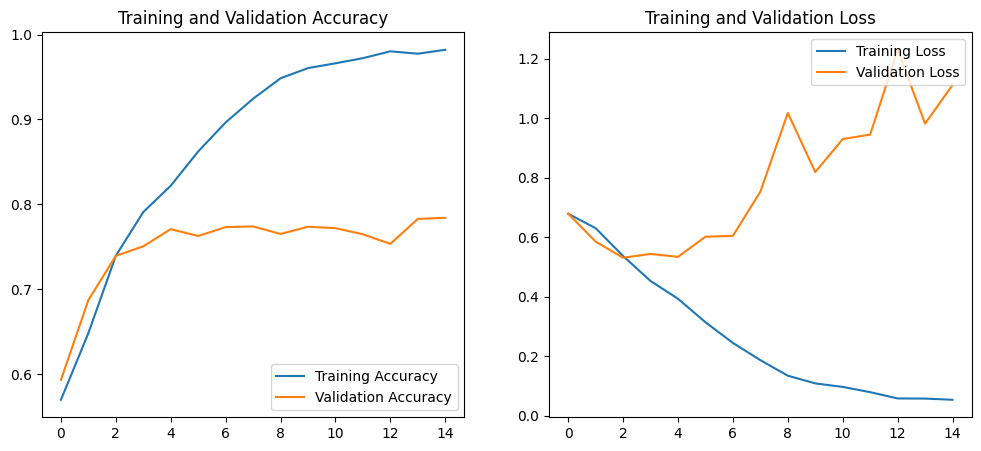

In [13]:
# Plot training curves
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)

In [14]:
# Evaluate on validation set
val_loss, val_acc = model.evaluate(val_ds)
print(f"\nValidation accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
print(f"Validation loss: {val_loss:.4f}")

 45/155 [=======>......................] - ETA: 1s - loss: 1.2324 - accuracy: 0.7681

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 90/155 [================>.............] - ETA: 0s - loss: 1.1414 - accuracy: 0.7757

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


155/155 [==============================] - 2s 13ms/step - loss: 1.1120 - accuracy: 0.7841

Validation accuracy: 0.7841 (78.41%)
Validation loss: 1.1120


1/1 [==============================] - 0s 159ms/step


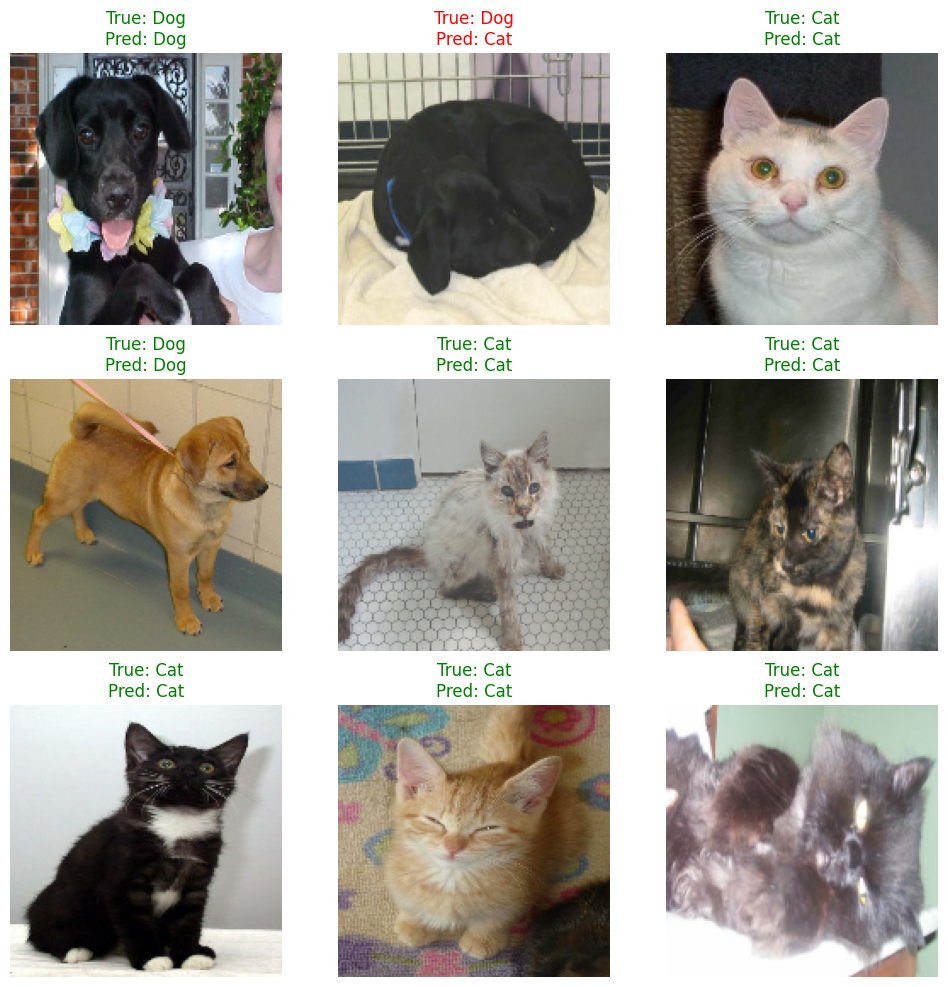

In [15]:
# Predict on sample images
plt.figure(figsize=(12, 12))
for images, labels in val_ds.take(1):
    preds = model.predict(images)
    preds = (preds > 0.5).astype(int).flatten()

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = class_names[int(labels[i])]
        pred_label = class_names[preds[i]]
        color = "green" if preds[i] == int(labels[i]) else "red"
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis("off")
plt.show()